# AlexNet

## Import

In [1]:
from torchvision import transforms, datasets
import torchvision 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Data Augmentation

In [2]:
img_size = 227

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

## Data (MNSIT 데이터 사용)

In [3]:
batch_size = 64

train_data = datasets.MNIST(root='./data/train',
                            train=True,
                            download=True,
                            transform=train_transform)


test_data = datasets.MNIST(root='./data/test',
                            train=False,
                            download=True,
                            transform=test_transform)


train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

In [4]:
train_iter = iter(train_loader)
check_batch = next(train_iter)
images, labels = check_batch

print(f"Input Shape : {images.shape}")

Input Shape : torch.Size([64, 1, 227, 227])


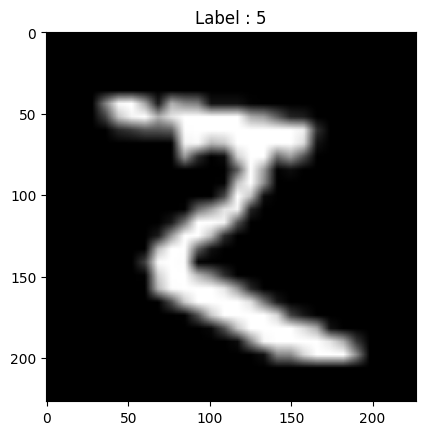

In [5]:
plt.title(f'Label : {train_data[0][1]}')
plt.imshow(train_data[0][0].squeeze().numpy(), cmap='gray')
plt.show()

## Model

In [6]:
NUM_LABEL = 10

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        
        self.net = nn.Sequential(
            # Layer 1
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.LocalResponseNorm(1, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            # Layer 2
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.LocalResponseNorm(1, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            # Layer 3
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            # Layer 4
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            # Layer 5
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2)
        )
        
        self.classifier = nn.Sequential(
            # FC Layer 1
            nn.Flatten(),
            nn.Linear(9216, 4098),
            nn.Dropout(),
            nn.ReLU(),
            # FC Layer 2
            nn.Linear(4098, 4098),
            nn.Dropout(),
            nn.ReLU(),
            # FC Layer 3
            nn.Linear(4098, NUM_LABEL)
        )
        
    def forward(self, images):
        net_output = self.net(images)
        fc_output = self.classifier(net_output)
        return fc_output        

## Trainer

In [7]:
class Trainer:
    def __init__(self, train_loader, test_loader, device):
        self.lr = 0.01
        self.epochs = 10
        self.momentum = 0.9
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.iter_point = 100
        
        self.model = AlexNet().to(self.device)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum)
        
    def train(self):
        
        for epoch in range(self.epochs):
            self.model.train()
            print(f"Epoch : {epoch+1}/{self.epochs}")
            print("Train ...")
            total_loss = 0
            for idx, batch in enumerate(self.train_loader):
                inputs, labels = batch[0].to(self.device), batch[1].to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                if idx % self.iter_point == 0:
                    print(f"Step : {idx}/{len(self.train_loader)}\nLoss : {loss.item():.4f}")
            
            epoch_loss = total_loss / len(self.train_loader)
            print(f"Train loss : {epoch_loss:.4f}")
            self.test()
            
    def test(self):
        with torch.no_grad():
            print("Test ...")
            self.model.eval()
            total_loss = 0
            total_match = 0
            for batch in self.test_loader:
                inputs, labels = batch[0].to(self.device), batch[1].to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                
                preds = torch.argmax(F.softmax(outputs, dim=-1))
                match = (preds == labels).sum().item()
                total_match += match
                
            epoch_loss = total_loss / len(self.test_loader)
            total_acc = total_match / len(self.test_loader.dataset)
            print(f"Test loss : {epoch_loss:.4f}\nTest ACC : {total_acc}")
                
if __name__ == "__main__" :
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    device = torch.device("cpu")
    trainer = Trainer(train_loader, test_loader, device)
    trainer.train()

        

Epoch : 1/10
Train ...
Step : 0/938
Loss : 2.3018
Step : 100/938
Loss : 2.2977
Step : 200/938
Loss : 2.3062
Step : 300/938
Loss : 2.3004
Step : 400/938
Loss : 1.2726
Step : 500/938
Loss : 0.4803
Step : 600/938
Loss : 0.3973
